1. Import necessary packages, and read in data
2. Preprocessing data and apriori feature selection
3. Random Forest: model training, tuning, and evaluation
4. Testing it out!

# Import necessary packages, and read in data

In [34]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [78]:
'''The line below is not code, please make it into code by putting in full path'''
#path = path to Titanic_full in your laptop

'The line below is not code, please make it into code by putting in full path'

In [36]:
df = pd.read_csv('Titanic_full(1).csv')
print(df.shape)
df.head(2)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# 2. Preprocessing data and apriori feature selection

In the broadest sense of the term, preprocessing can also include feature selection. Here, we will use our
rationale to feature select. What do the column names mean, does it make sense to what we are trying to do, and should we keep it or drop it?

There are different ways to think about it. For now, let's drop Name, Cabin and Ticket columns.

Let's see if this makes a difference.

In [37]:
'''Keep aside test data first'''

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


df_trn_val,df_tst = mydf_splitter(df,1150)

print(df_trn_val.shape,df_tst.shape)

(1150, 12) (159, 12)


In [38]:
 df_trn_val1 = df_trn_val.drop(["Name","Cabin","Ticket"],axis = 1)
print(df_trn_val1.shape)
df_trn_val1.head(3)

(1150, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


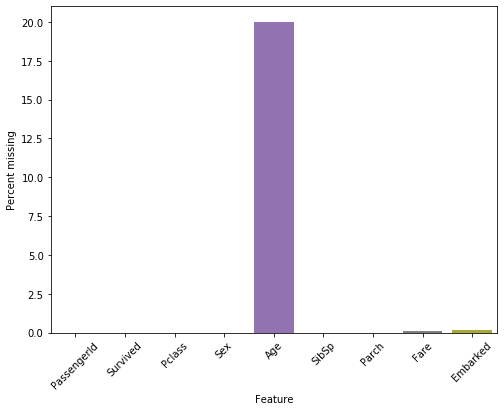

In [39]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = df_trn_val1.isnull().sum()/len(df_trn_val1)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [40]:
#Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [41]:
'''Define impute functions. Impute categorical NaNs with -1, 
where we add 1 to make it 0. For each 
continuous variables, we impute missing values with median values of that
column, and for every variable
where any rows were imputed, add a separate 'imputed or not' column'''

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [42]:
df_trn_val2 = str_to_cat(df_trn_val1)
print(df_trn_val2.shape)
df_trn_val2.head(3)

(1150, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


In [43]:
df_trn_val3,my_table = mydf_preprocessor(df_trn_val2,null_table = None)
print(df_trn_val3.shape)
df_trn_val3.head(3)

(1150, 11)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na,Fare_na
0,1,0,3,2,22.0,1,0,7.2500,3,False,False
1,2,1,1,1,38.0,1,0,71.2833,1,False,False
2,3,1,3,1,26.0,0,0,7.9250,3,False,False


In [44]:
my_table

{'Age': 28.0, 'Fare': 14.4542}

In [45]:
x = df_trn_val3.drop('Survived', axis=1)
y = df_trn_val3['Survived']

In [46]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, random_state=1)
print(x_trn.shape,x_val.shape,y_trn.shape,y_val.shape)

(862, 10) (288, 10) (862,) (288,)


# Random Forest: model training, tuning, and evaluation

In [47]:
mod_1 = RandomForestClassifier(n_jobs = -1, n_estimators = 10,
                                 bootstrap = True)
mod_1.fit(x_trn,y_trn)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [48]:
y_prd = mod_1.predict(x_val)
accuracy_score(y_val,y_prd)

0.7256944444444444

In [49]:
mod_2 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000,
                                 bootstrap = True)
mod_2.fit(x_trn,y_trn)
y_prd2 = mod_2.predict(x_val)
accuracy_score(y_val,y_prd2)

0.7430555555555556

In [50]:
mod_3 = RandomForestClassifier(n_jobs = -1, n_estimators = 1000,max_features = 0.25,
                               bootstrap = True)
mod_3.fit(x_trn,y_trn)
y_prd3 = mod_3.predict(x_val)
accuracy_score(y_val,y_prd3)

0.7465277777777778

# 4.  Testing it out!

In [51]:
'''Preprocess test set exactly like the train and validation sets'''

df_tst1 = df_tst.drop(["Name","Cabin","Ticket"],axis = 1)
print(df_tst1.shape)
df_tst1.head(3)

(159, 9)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1150,1151,1,3,male,21.0,0,0,7.7750,S
1151,1152,0,3,male,36.5,1,0,17.4000,S
1152,1153,1,3,male,21.0,0,0,7.8542,S


In [52]:
df_tst2 = str_to_cat(df_tst1)
df_tst2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [53]:
df_tst2,my_table1 = mydf_preprocessor(df_tst1,
                                         null_table = my_table)
print(df_tst2.shape)
df_tst2.head(3)

(159, 11)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_na,Fare_na
1150,1151,1,3,2,21.0,0,0,7.7750,3,False,False
1151,1152,0,3,2,36.5,1,0,17.4000,3,False,False
1152,1153,1,3,2,21.0,0,0,7.8542,3,False,False


In [54]:
# Now, let's split out the X and Y variables (vertical split of the dataframe)
#Remember we did this previously!


y_tst = df_tst2["Survived"]
x_tst = df_tst2.drop(["Survived"],axis = 1)

print(x_tst.shape,y_tst.shape)

(159, 10) (159,)


In [55]:
y_prd_tst = mod_1.predict(x_tst)
accuracy_score(y_tst,y_prd_tst)

0.559748427672956

In [56]:
'''Looks like we are improving! With a dataset of this size, best way forward is more
feature engineering. Take a look at all the Kaggle solutions to this competition and
all the different feature engineering methods! When we get to Neural Networks'''

'Looks like we are improving! With a dataset of this size, best way forward is more\nfeature engineering. Take a look at all the Kaggle solutions to this competition and\nall the different feature engineering methods! When we get to Neural Networks'

# Part2B: Gradient Boosting Implementation on given preprocessed data

In [57]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.metrics import average_precision_score
from sklearn.ensemble import AdaBoostClassifier as ab
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve


from sklearn.linear_model import SGDClassifier as sg
import matplotlib.pyplot as plt
import numpy as np

In [58]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(n_estimators=120, learning_rate=0.5, max_features=2, max_depth = 2, random_state = 0) 
gbrt.fit(x_trn, y_trn)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=2,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=120,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [59]:
y_prd = gbrt.predict(x_val)
accuracy_score(y_val, y_prd)


0.7291666666666666

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_prd))
print()
print("Classification Report")
print(classification_report(y_val, y_prd))

Confusion Matrix:
[[144  24]
 [ 54  66]]

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       168
           1       0.73      0.55      0.63       120

    accuracy                           0.73       288
   macro avg       0.73      0.70      0.71       288
weighted avg       0.73      0.73      0.72       288



In [61]:
# ROC curve and Area-Under-Curve (AUC)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

y_scores = gbrt.decision_function(x_val)
fpr_gb, tpr_gb, _ = roc_curve(y_val, y_scores)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

Area under ROC curve = 0.78


# HyperParameter Tuning(n estimators, learning rate...)

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
learning_rates = [0.001,0.01,0.05, 0.1, 0.25, 0.5, 0.75, 1]
max_test_accuracy_score =[]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=53, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(x_trn,y_trn)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(x_trn,y_trn)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(x_val,y_val)))
    print("Accuracy score (testing): {0:.3f}".format(gb.score(x_tst, y_tst)))
    max_test_accuracy_score.append(gb.score(x_tst, y_tst))
    print()

Learning rate:  0.001
Accuracy score (training): 0.638
Accuracy score (validation): 0.583
Accuracy score (testing): 0.541

Learning rate:  0.01
Accuracy score (training): 0.638
Accuracy score (validation): 0.583
Accuracy score (testing): 0.541

Learning rate:  0.05
Accuracy score (training): 0.768
Accuracy score (validation): 0.726
Accuracy score (testing): 0.465

Learning rate:  0.1
Accuracy score (training): 0.791
Accuracy score (validation): 0.736
Accuracy score (testing): 0.465

Learning rate:  0.25
Accuracy score (training): 0.813
Accuracy score (validation): 0.750
Accuracy score (testing): 0.453

Learning rate:  0.5
Accuracy score (training): 0.831
Accuracy score (validation): 0.750
Accuracy score (testing): 0.465

Learning rate:  0.75
Accuracy score (training): 0.848
Accuracy score (validation): 0.729
Accuracy score (testing): 0.547

Learning rate:  1
Accuracy score (training): 0.868
Accuracy score (validation): 0.701
Accuracy score (testing): 0.491



In [63]:
np.argmax(max_test_accuracy_score)

6

In [64]:
import numpy as np 
from sklearn.metrics import mean_squared_error
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(x_val)]
bst_n_estimators=np.argmin(errors)
bst_n_estimators

55

In [68]:
gbrt_best = GradientBoostingClassifier(max_depth=2,n_estimators=bst_n_estimators, learning_rate=0.01,random_state=7) 
gbrt_best.fit(x_trn,y_trn)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=55,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=7, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [69]:
y_vld_prd = gbrt_best.predict(x_val)
accuracy_score(y_val, y_vld_prd.round())

0.7222222222222222

# Evaluating test set accuracy with the trained model

In [70]:
y_tst_prd = gbrt_best.predict(x_tst)
accuracy_score(y_tst, y_tst_prd.round())

0.5408805031446541

Confusion Matrix: Testing Data
[[86  0]
 [73  0]]


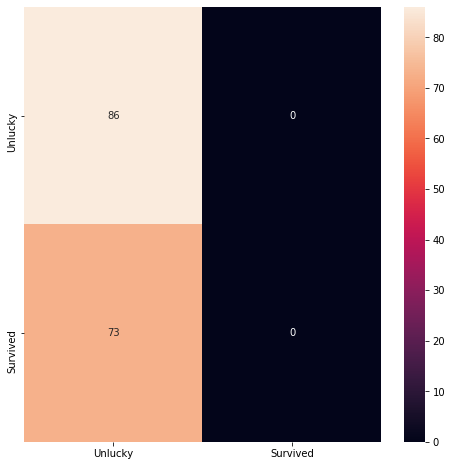

In [71]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("Confusion Matrix: Testing Data")
print(confusion_matrix(y_tst, y_tst_prd.round()))
gb_cmatrix = confusion_matrix(y_tst, y_tst_prd.round())
gb_df = pd.DataFrame(gb_cmatrix)
plt.figure(figsize = (8,8))
sns.heatmap(gb_df, xticklabels = ["Unlucky","Survived"],
            yticklabels = ["Unlucky","Survived"],annot = True)

In [72]:
# print("Classification Report")
print(classification_report(y_tst, y_tst_prd.round()))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        86
           1       0.00      0.00      0.00        73

    accuracy                           0.54       159
   macro avg       0.27      0.50      0.35       159
weighted avg       0.29      0.54      0.38       159



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ROC curve and Area-Under-Curve (AUC)

Area under ROC curve = 0.50


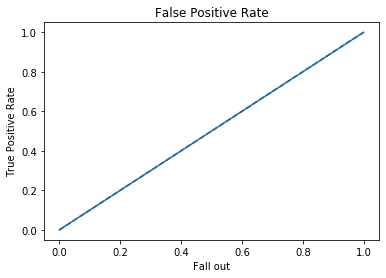

In [73]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

y_tst_scores_gb = gb.decision_function(x_tst)
tpr_gb,fpr_gb,_ = roc_curve(y_tst, y_tst_prd.round())
roc_auc_gb = auc(tpr_gb,fpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

plt.plot([0,1],[0,1],'k--')
plt.plot(tpr_gb,fpr_gb, label='GB')
plt.xlabel('Fall out')
plt.ylabel('True Positive Rate')
plt.title('False Positive Rate')
plt.show()


# Evaluating accuracy on different Classifiers

In [74]:

model_name=['RandomForestClassifier','KNeighborsClassifier','GradientBoostingClassifier','AdaBoostClassifier','DecisionTreeClassifier','LogisticRegression']
models_list= [RF(n_estimators=200, max_leaf_nodes=16, n_jobs=-1, random_state=42),KNN(),GB(max_depth=4,n_estimators=100),ab(),dt(),LR(solver='liblinear', penalty='l1')]
for i, j in zip(model_name, models_list):
    scores = cross_val_score(j, x_trn, y_trn, cv=5)
    score1 = cross_val_score(j, x_val, y_val, cv=5)
    score2 = cross_val_score(j, x_tst, y_tst, cv=5)
    print(i+"--"+ "Training Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print(i+"--"+ "Validation Accuracy: %0.2f (+/- %0.2f)" % (score1.mean(), score1.std() * 2))
    print(i+"--"+ "testing Accuracy: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std() * 2))
    print()

RandomForestClassifier--Training Accuracy: 0.78 (+/- 0.04)
RandomForestClassifier--Validation Accuracy: 0.72 (+/- 0.09)
RandomForestClassifier--testing Accuracy: 0.50 (+/- 0.11)

KNeighborsClassifier--Training Accuracy: 0.63 (+/- 0.03)
KNeighborsClassifier--Validation Accuracy: 0.60 (+/- 0.05)
KNeighborsClassifier--testing Accuracy: 0.50 (+/- 0.10)

GradientBoostingClassifier--Training Accuracy: 0.76 (+/- 0.09)
GradientBoostingClassifier--Validation Accuracy: 0.72 (+/- 0.08)
GradientBoostingClassifier--testing Accuracy: 0.48 (+/- 0.16)

AdaBoostClassifier--Training Accuracy: 0.74 (+/- 0.06)
AdaBoostClassifier--Validation Accuracy: 0.70 (+/- 0.11)
AdaBoostClassifier--testing Accuracy: 0.48 (+/- 0.09)

DecisionTreeClassifier--Training Accuracy: 0.71 (+/- 0.06)
DecisionTreeClassifier--Validation Accuracy: 0.71 (+/- 0.06)
DecisionTreeClassifier--testing Accuracy: 0.48 (+/- 0.04)

LogisticRegression--Training Accuracy: 0.75 (+/- 0.06)
LogisticRegression--Validation Accuracy: 0.71 (+/- 0.11)

# Part3: Evaluating increasing the number of decision trees (n_estimators), increases classifier performance and/or generalizability

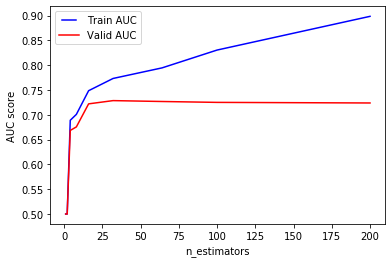

In [75]:
from matplotlib.legend_handler import HandlerLine2D

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
valid_results = []

for estimator in n_estimators:
    model = GradientBoostingClassifier(n_estimators=estimator)
    model.fit(x_trn, y_trn)
    
    train_pred=model.predict(x_trn)
    fpr, tpr, thresholds= roc_curve(y_trn,train_pred)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    
    
    y_pred=model.predict(x_val)
    fpr_v, tpr_v, thresholds= roc_curve(y_val,y_pred)
    roc_auc_v = auc(fpr_v, tpr_v)
    valid_results.append(roc_auc_v)
    
  
line1, =plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, =plt.plot(n_estimators, valid_results, 'r', label="Valid AUC")


plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

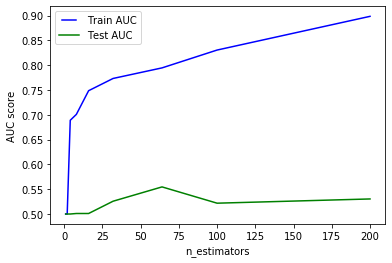

In [76]:
from matplotlib.legend_handler import HandlerLine2D

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
    model = GradientBoostingClassifier(n_estimators=estimator)
    model.fit(x_trn, y_trn)
    
    train_pred=model.predict(x_trn)
    fpr, tpr, thresholds= roc_curve(y_trn,train_pred)
    roc_auc = auc(fpr, tpr)
    train_results.append(roc_auc)
    
    
    y_prd_test=model.predict(x_tst)
    fpr_t, tpr_t, thresholds= roc_curve(y_tst,y_prd_test)
    roc_auc_t = auc(fpr_t, tpr_t)
    test_results.append(roc_auc_t)
    
line1, =plt.plot(n_estimators, train_results, 'b', label="Train AUC")    
line3, =plt.plot(n_estimators, test_results, 'g', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()


# Part-2A How is Gradient Boosting different from Bagging  

Bagging and Boosting are both ensemble methods in Machine Learning, where a set of weak learners are combined to create a strong learner that obtains better performance than a single one.


1)  Training stage:
While the training stage is parallel for Bagging (i.e., each model is built independently), Boosting builds the new learner in a sequential way, meaning: In Boosting algorithms each classifier is trained on data, taking into account the previous classifiers’ success. After each training step, the weights are redistributed. Misclassified data increases its weights to emphasise the most difficult cases. In this way, subsequent learners will focus on them during their training.


2)  To predict the class of new data we only need to apply the N learners to the new observations:
In Bagging the result is obtained by averaging the responses of the N learners (or majority vote). However, Boosting assigns a second set of weights, this time for the N classifiers, in order to take a weighted average of their estimates.In the Boosting training stage, the algorithm allocates weights to each resulting model. A learner with good a classification result on the training data will be assigned a higher weight than a poor one. So when evaluating a new learner, Boosting needs to keep track of learners’ errors, too


3) It generally depends on the data, the simulation and the circumstances :
Bagging and Boosting decrease the variance of single estimate as they combine several estimates from different models. So the result may be a model with higher stability.

If the problem is that the single model gets a very low performance, Bagging will rarely get a better bias. However, Boosting could generate a combined model with lower errors as it optimises the advantages and reduces pitfalls of the single model.

If the difficulty of the single model is over-fitting, then Bagging is the best option. Boosting for its part doesn’t help to avoid over-fitting; in fact, this technique is faced with this problem itself

4) Both are ensemble methods to get N learners from 1 learner:
But, while they are built independently for Bagging, Boosting tries to add new models that do well where previous models fail.


5) Both generate several training data sets by random sampling:
But only Boosting determines weights for the data to tip the scales in favor of the most difficult cases.


6) Both make the final decision by averaging  the N learners (or taking the majority of them:
But it is an equally weighted average for Bagging and a weighted average for Boosting, more weight to those with better performance on training data.


7) Both are good at reducing variance and provide higher stability:
But only Boosting tries to reduce bias. On the other hand, Bagging may solve the over-fitting problem, while Boosting can increase it.